# Train FCN for semantic segmentation

You must only define model structure and choose loss function

After model will work, optionally add some augmentation to improve results

## Load the data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.



In [1]:
! wget http://fmb.images.gan4x4.ru/hse/midv500p.zip
! unzip -q midv500p.zip

--2025-02-06 13:08:09--  http://fmb.images.gan4x4.ru/hse/midv500p.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183651 (8.8M) [application/zip]
Saving to: ‘midv500p.zip.1’

midv500p.zip.1      100%[===================>]   8.76M  2.11MB/s    in 5.4s    

2025-02-06 13:08:15 (1.63 MB/s) - ‘midv500p.zip.1’ saved [9183651/9183651]

replace midv500p/val/image/553.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace midv500p/val/image/554.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace midv500p/val/image/554.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Dataset.
You can use it without modification

In [2]:
from torch.utils.data import Dataset
from torchvision import tv_tensors
from PIL import Image, ImageFile
from torchvision.io import read_image
import glob

# To bypass error on corrupted files: https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images
# ImageFile.LOAD_TRUNCATED_IMAGES = False

class MaskDataset(Dataset):
    def __init__(
        self,
        train_part=True,
        transform=None,  # for image only
        transforms=None,  # for image and mask
        target_transform=None,  # for mask only
        path="midv500p",
    ):
        self.transform = transform
        self.transforms = transforms
        self.target_transform = target_transform
        path += "/train" if train_part else "/val"
        files = glob.glob(path + "/image/*")
        self.loaded_images = []
        self.loaded_masks = []

        for filename in files:  # cache all data in memory
            self.loaded_images.append(read_image(filename) / 255)
            mask_fn = filename.replace("image", "mask").replace("jpg", "png")
            self.loaded_masks.append(read_image(mask_fn) / 255)

    def __getitem__(self, i):
        img = self.loaded_images[i]
        mask = self.loaded_masks[i]
        if self.transform is not None:
            img = self.transform(img)
        if self.transforms is not None:
            img, mask = self.transforms(tv_tensors.Image(img), tv_tensors.Mask(mask))
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.loaded_images)

Dataloaders initialization

In [3]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader

v2_transforms = v2.Compose(
    [
        v2.Resize((224, 224), antialias=True),  # antialias to suppress warning
        v2.ToDtype(torch.float32, scale=True),
    ]
)

trainset = MaskDataset(train_part=True, transforms=v2_transforms)
valset = MaskDataset(train_part=False, transforms=v2_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)


Lets show some data

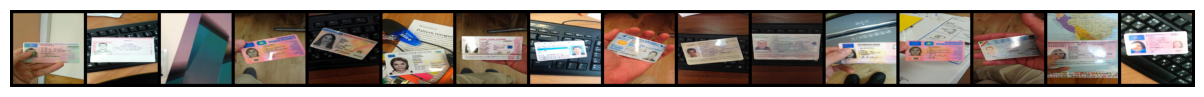

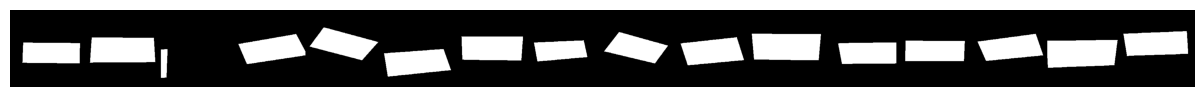

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose((img_grid * 255).numpy().astype(np.uint8), (1, 2, 0)))


images, masks = next(iter(train_loader))

show(images)
show(masks)

# Code for train

You must select Loss function

Обоснование выбора комбинации BCE + IoU Loss:

Binary Cross Entropy Loss – хорошо подходит для бинарной классификации, модель будет правильно предсказывать класс для отдельного пикселя

Intersection over Union Loss (JaccardLoss) – измеряет степень пересечения между предсказанной и истинной маской, учитывает форму и границы объектов

Объединяя BCEWithLogitsLoss (вызывает сигмоиду внутри) и IoU Loss, оптимизируем модель для точной классификации пикселей и получения корректных контуров. Данная комбинация учитывает как локальные, так и глобальные аспекты предсказаний модели

In [5]:
!pip install segmentation-models-pytorch

In [6]:
import torch.nn as nn
import segmentation_models_pytorch as smp

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.jaccard_loss = smp.losses.JaccardLoss(mode="binary")

    def forward(self, pred, target):
        loss_bce = self.bce_loss(pred, target)
        loss_jaccard = self.jaccard_loss(pred, target)

        return loss_bce + loss_jaccard


In [7]:
loss_fn = CombinedLoss()

## Define your model structure here

Use [UNet](https://arxiv.org/pdf/1505.04597.pdf) - like structure.
But  decrease number of layers for simplicity.
Original images has 224x224 resolution.

In [8]:
from torch.nn import *

class MiniUnet(Module):
    def __init__(self, num_classes = 1):
        super(MiniUnet, self).__init__()

        self.down1 = self.conv_block(                                             # 1st downsample: 224x224 → 112x112
            in_channels=3,
            out_channels=64,
            pooling=True)

        self.down2 = self.conv_block(                                             # 2nd downsample: 112x112 → 56x56
            in_channels=64,
            out_channels=128,
            pooling=True)

        self.bottleneck = self.conv_block(                                        # block without pooling (56x56)
            in_channels=128,
            out_channels=256,
            pooling=False)

        self.up1 = nn.ConvTranspose2d(                                            # 1st upsample: 56x56 → 112x112; concatenate with output of 1st downsample
            in_channels=256,
            out_channels=64,
            kernel_size=2,
            stride=2)

        self.conv_up1 = self.conv_block(                                          # after concatenating channels: 64+64=128, so apply a convolutional block to result in 64
            in_channels=128,
            out_channels=64,
            pooling=False)

        self.up2 = nn.ConvTranspose2d(                                            # 2nd upsample: 112x112 → 224x224
            in_channels=64,
            out_channels=64,
            kernel_size=2,
            stride=2)

        self.final = nn.Conv2d(                                                   # final layer to obtain mask
            in_channels=64,
            out_channels=num_classes,
            kernel_size=1)

    def conv_block(self, in_channels, out_channels, pooling=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),       # 3×3 convolution
            nn.ReLU(inplace=True),                                                # activation func, resets all negative values in tensor to speed up learning
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),      # 3×3 with same number of input-output channels
            nn.ReLU(inplace=True)
        ]

        if pooling:                                                               # possible to disable pooling to use it at upsampling
            layers.append(nn.MaxPool2d(kernel_size=2))

        return nn.Sequential(*layers)                                             # sequence of operations that can be applied to input data

    def forward(self, x):
        d1 = self.down1(x)                                                        # [batch_size, 64, 112, 112]
        d2 = self.down2(d1)                                                       # [batch_size, 128, 56, 56]
        b = self.bottleneck(d2)                                                   # [batch_size, 256, 56, 56]
        u1 = self.up1(b)                                                          # [batch_size, 64, 112, 112]
        u1 = torch.cat([u1, d1], dim=1)                                           # [batch_size, 64+64=128, 112, 112]
        u1 = self.conv_up1(u1)                                                    # [batch_size, 64, 112, 112]
        u2 = self.up2(u1)                                                         # [batch_size, 64, 224, 224]
        out = self.final(u2)                                                      # [batch_size, num_classes, 224, 224]

        return out


## Train the model

Select appopriate loss and metric


Accuracy не подходит, т.к. сегментация подразумевает дисбаланс классов (фон > объект)

IoU – показывает, насколько предсказанная область совпадает с истинной (сильнее штрафует за лишние предсказания)

Dice Score – аналог F1-Score для сегментации

BCEWithLogitsLoss + JaccardLoss (чем меньше, тем точнее) – оценка пиксельной точности и общей формы объекта

reduction="macro" усредняет по классам

In [20]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mini_unet = MiniUnet(num_classes=1).to(device)
optimizer = optim.Adam(mini_unet.parameters(), lr=1e-4)

def train(model, train_loader, optimizer, loss_fn, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_iou = 0
        total_dice = 0
        num_batches = len(train_loader)

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            tp, fp, fn, tn = smp.metrics.get_stats(preds, masks.long(), mode="binary")
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

            total_iou += iou.item()
            total_dice += dice.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/num_batches:.4f}, IoU: {total_iou/num_batches:.4f}, Dice: {total_dice/num_batches:.4f}")


In [21]:
train(mini_unet, train_loader, optimizer, loss_fn, epochs=15)

Epoch 1/15, Loss: 1.4601, IoU: 0.0000, Dice: 0.0000
Epoch 2/15, Loss: 1.3938, IoU: 0.0215, Dice: 0.0369
Epoch 3/15, Loss: 0.9022, IoU: 0.5799, Dice: 0.7276
Epoch 4/15, Loss: 0.8148, IoU: 0.6116, Dice: 0.7576
Epoch 5/15, Loss: 0.7608, IoU: 0.6313, Dice: 0.7724
Epoch 6/15, Loss: 0.7428, IoU: 0.6379, Dice: 0.7779
Epoch 7/15, Loss: 0.7246, IoU: 0.6478, Dice: 0.7850
Epoch 8/15, Loss: 0.7185, IoU: 0.6508, Dice: 0.7875
Epoch 9/15, Loss: 0.7164, IoU: 0.6494, Dice: 0.7871
Epoch 10/15, Loss: 0.7000, IoU: 0.6598, Dice: 0.7939
Epoch 11/15, Loss: 0.6883, IoU: 0.6643, Dice: 0.7969
Epoch 12/15, Loss: 0.6805, IoU: 0.6697, Dice: 0.8008
Epoch 13/15, Loss: 0.6964, IoU: 0.6608, Dice: 0.7938
Epoch 14/15, Loss: 0.6714, IoU: 0.6762, Dice: 0.8052
Epoch 15/15, Loss: 0.6724, IoU: 0.6763, Dice: 0.8054


# Display results

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def show_valset_pred(model, cols=16):
    model.to(device)
    images, pred_masks = [], []
    try:
        tmp = valset.transform
        valset.transform = None
        for batch in valset:
            with torch.no_grad():
                img, mask = batch
                images.append(img.unsqueeze(0))
                output = model(img.unsqueeze(0).to(device))
                pred_masks.append(output.cpu())

    finally:
        valset.transform = tmp
    show(torch.stack(images).squeeze()[:cols, ...])
    binary_mask = torch.stack(pred_masks) > 0.5
    show(binary_mask.squeeze(1).float()[:cols, ...])

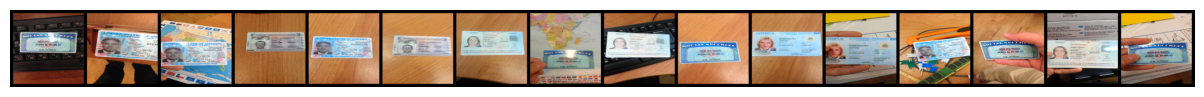

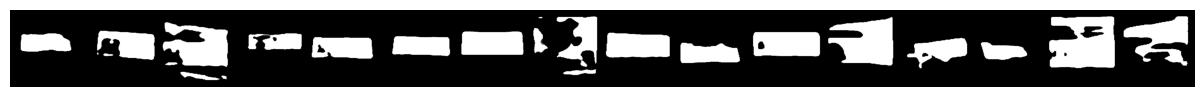

In [23]:
show_valset_pred(mini_unet, 16)

# Микровывод

Если документ на контрастном фоне – работает хорошо. Если сливается с фоном или есть мелкие детали – беда...

// хотя на 13-й вполне неплохо

на 15-й эпохе:
Loss: 0.6724, IoU: 0.6763, Dice: 0.8054

loss немного поднялась, как и метрики – о переобучении сложно судить

есть подозрения, что до 3-й эпохи градиентный спуск застрял в локальном минимуме

возможные улучшения: рассмотреть подбор коэффициентов при сложении функций потерь (в текущей реализации предполагалось, что лоссы имеют схожие масштабы)

#Ideas for extra work

* Build segmentation model using pretrained backbone model from [SMP](https://github.com/qubvel/segmentation_models.pytorch) and compare results with obtained from your model
* Combine two different loss e.g. BCE and [IoULoss](https://smp.readthedocs.io/en/latest/losses.html#jaccardloss)
* Add augmentation from [Albumentation](https://albumentations.ai/)